# NLTK

### Project Goal: 
To compare customer sentiment regarding attractions at three Disneyland locations (Anaheim, Paris, and Hong Kong) using sentiment analysis, emotion detection, and n-gram associations. To identify keywords using topic modeling that can help Disney determine visitor pain points and improve park experience.<br>
### Dataset:
Dataset is from [Kaggle](https://www.kaggle.com/arushchillar/disneyland-reviews) containing 42,000 reviews from TripAdvisor about three Disneyland branch locations: California, Paris, Hong Kong. here are 19,406 reviews about Anaheim, 13,630 about Paris, and 9,620 about Hong Kong. Data variables include Review_ID, Rating, Year_Month, Reviewer_Location, Review_Text, and Disneyland_Branch.<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import state_union
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import string
pd.options.mode.chained_assignment = None  # default='warn'
#nltk.download('averaged_perceptron_tagger')

In [2]:
%matplotlib inline
sns.set_style("white")

class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

## Load Data

In [3]:
Disneyland = pd.read_csv ('DisneylandReviews.csv', encoding='unicode_escape')
Disneyland.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
Disneyland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [5]:
#To select rows whose column value equals 'missing' in 'Year_Month':
missing = Disneyland.loc[Disneyland['Year_Month'] == 'missing']
#keep the missing rows seperate
Disneyland = Disneyland[Disneyland.Year_Month != 'missing']

In [6]:
#get year from the year_month
Disneyland['Year'] = pd.to_datetime(Disneyland['Year_Month']).dt.strftime('%Y')

In [7]:
# Using apply(str) method
Disneyland['Month']=Disneyland['Year_Month'].apply(str)
Disneyland['Month']= Disneyland['Month'].apply(lambda x: x[5:])

In [8]:
#join back the missing in year_month
Disneyland = Disneyland.append(missing)
#Disneyland.tail()

C:\Users\chand\AppData\Local\Temp\ipykernel_12780\470078404.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Disneyland = Disneyland.append(missing)


#### Rename the fields in Branch column
There are 3 fields in Branch column we will rename them for our convenience as following

In [9]:
Disneyland['Branch'] = Disneyland['Branch'].replace({'Disneyland_HongKong': 'HongKong', 
                                                     'Disneyland_California':'California', 
                                                     'Disneyland_Paris':'Paris'})

## Text analytics

In [10]:
reviews = Disneyland['Review_Text']
#reviews

In [11]:
#strip ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

#only interested in reviews written in English
def get_language(text):
    words = set(nltk.wordpunct_tokenize(text.lower()))
    lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
    if lang == 'english':
        return True
    else:
        return False

In [12]:
#change type to string
reviews = reviews.astype('str')

In [13]:
eng_rev = reviews[reviews.apply(get_language)]
#eng_rev.head()
print(len(eng_rev)) #5 reviews not in english

42642


In [14]:
#remove duplicates if any
eng_rev.drop_duplicates(inplace=True)
len(eng_rev)

42619

In [15]:
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")


In [16]:
#lemmatize
def clean_comments(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemmatized = [token.lemma_ for token in doc]
    return lemmatized

In [17]:
#apply function to clean and lemmatize comments
lemm = eng_rev.map(clean_comments)

#lowercase words
lemm = lemm.map(lambda x: [word.lower() for word in x])

In [18]:
#turn all comments' tokens into one single list
unlist_rev = [item for items in lemm for item in items]
#unlist_rev = [x.strip('') for x in unlist_rev]
#unlist_rev

In [22]:
#remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
  
cleaned_rev = [word for word in unlist_rev if word.lower() not in stop_words]

#remove custom stop words
my_stopwords = ['park', 'disney', 'disneyland', 'disney land', 'disney world',  'disneyworld',
                'tokyo','paris', 'anaheim','california', 'hong kong','kong', 'hong']

cleaned_rev = [word for word in cleaned_rev if word not in my_stopwords]


#remove spaces
cleaned_rev = [w for w in cleaned_rev if w != ' '] 
cleaned_rev = [w for w in cleaned_rev if w != '  '] 
cleaned_rev = [w for w in cleaned_rev if w != '   ']
#cleaned_rev

## Using n grams to find word patterns

In [23]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(cleaned_rev)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_rev)

### bigrams

In [24]:
bigram_freq = bigramFinder.ngram_fd.items()

In [25]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [26]:
bigramFreqTable.head(30).reset_index(drop=True)

,bigram,freq
0,"(fast, pass)",7580
1,"(year, old)",4389
2,"(space, mountain)",3819
3,"(go, back)",3338
4,"(one, day)",3045
5,"(wait, time)",2640
6,"(small, world)",2413
7,"(great, time)",2321
8,"(main, street)",2311
9,"(make, sure)",2237


In [27]:
#might be more meaningful if we can get adjectives and nouns 

#function to filter for ADJ/NN bigrams

def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [28]:
#takes awhile to run
bigram_filter = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]
bigram_filter.head(10)

,bigram,freq
73,"(space, mountain)",3819
1640,"(wait, time)",2640
12,"(small, world)",2413
552,"(great, time)",2321
6,"(main, street)",2311
80,"(cast, member)",2155
13111,"(indiana, jones)",2020
2827,"(first, time)",2012
5786,"(thunder, mountain)",1921
111,"(place, earth)",1845


In [29]:
test_string = bigram_filter['bigram'].tolist()
test_string[1]
#type(test_string)
#combine tuple
test_string[1][0] +'_' + test_string[1][1] 

#combine all tuples in df
bigram = [ ]
for c in range(0, len(test_string)):
    bigram.append(test_string[c][0] +'_' + test_string[c][1]) 

bigram_filter['bigram_combo'] = bigram

In [30]:
top20_bigram = bigram_filter[:20]

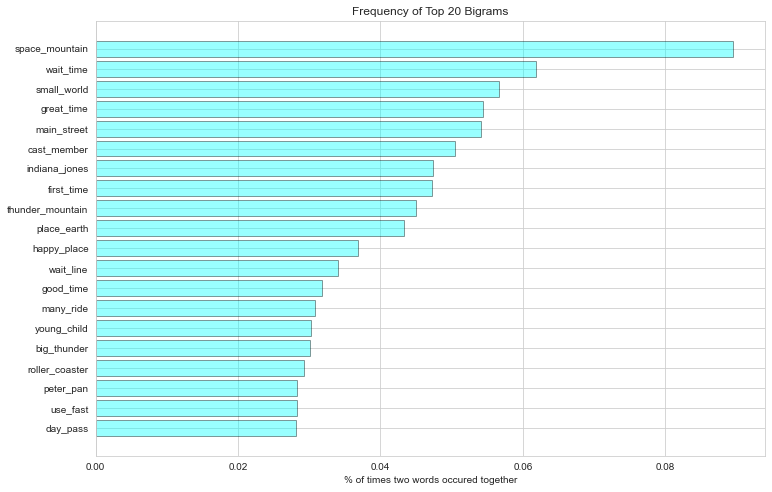

In [31]:
# Create Figure
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12,8))
plt.barh(top20_bigram['bigram_combo'], top20_bigram['freq']/len(Disneyland), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of times two words occured together")
plt.gca().invert_yaxis()
plt.title("Frequency of Top 20 Bigrams")
#plt.savefig("output\disney_topbigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

### trigrams

In [32]:
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable.head(5).reset_index(drop=True)

,trigram,freq
0,"(happy, place, earth)",1272
1,"(get, fast, pass)",1168
2,"(use, fast, pass)",1075
3,"(big, thunder, mountain)",988
4,"(fast, pass, system)",614


In [33]:
#filter NN and ADJ in trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stop_words:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [34]:
trigram_filter = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
trigram_filter.head(10)

,trigram,freq
635,"(happy, place, earth)",1272
6261,"(use, fast, pass)",1075
6545,"(big, thunder, mountain)",988
4548,"(year, old, daughter)",517
578,"(lion, king, show)",459
1320,"(toy, story, land)",428
4331,"(ride, space, mountain)",401
3144,"(wait, time, ride)",356
470,"(dream, come, true)",351
13426,"(year, old, son)",343


In [35]:
test_string2 = trigram_filter['trigram'].tolist()

trigram = [ ]
for c in range(0, len(test_string2)):
    trigram.append(test_string2[c][0] + '_' + test_string2[c][1] + '_' + test_string2[c][2]) 

trigram_filter['trigram_combo'] = trigram
top20_trigram = trigram_filter[:20]

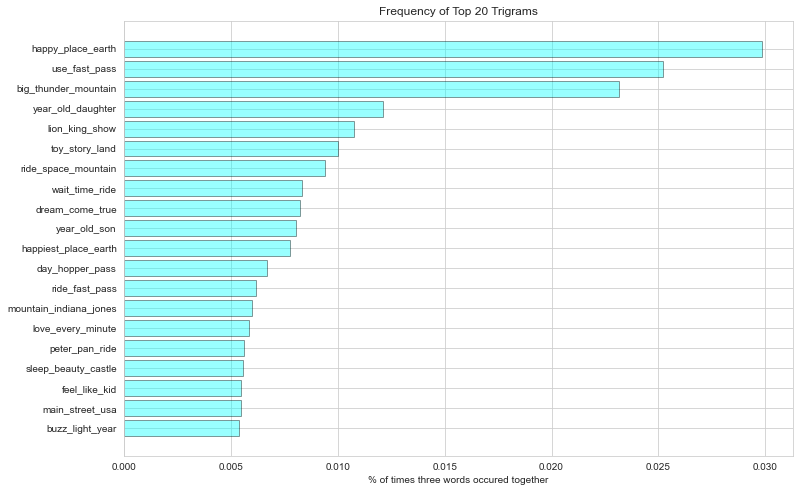

In [36]:
# Create Figure
fig, ax = plt.subplots(figsize=(12,8))
#plot frequency of trigram that occurs out of all ca reviews
plt.barh(top20_trigram['trigram_combo'], top20_trigram['freq']/len(Disneyland), color ='cyan', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of times three words occured together")
plt.gca().invert_yaxis()
#plt.ylabel("Counts")
plt.title("Frequency of Top 20 Trigrams")
#plt.savefig("output\disney_hk_toptrigram.jpg", bbox_inches='tight', dpi = 300)
plt.show()

- Trigram show a lot of rides! Which rides/attractions they went to, what kind of tickets they purchased, duration of stay/visit

## Find reviews where ngram occurs

In [55]:
from nrclex import NRCLex

emotion = []
for i in range(len(Disneyland)):
    emotions = NRCLex(Disneyland['Review_Text'][i])
    emotion.append(emotions.top_emotions[0][0])
Disneyland['emotion'] = emotion

In [56]:
specific_words = ['toy story land']
query = '|'.join(specific_words)
Disneyland['query_match'] = Disneyland['Review_Text'].str.lower().str.contains(query)
Disneyland.head()


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,query_match,emotion
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,False,positive
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,False,positive
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,False,positive
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,False,positive
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,False,anger


In [57]:
#what are people saying about space mountain?
query_sample = Disneyland[Disneyland['query_match'] == True]

In [58]:
#do ngram association again

query_reviews = query_sample['Review_Text']
query_reviews = query_reviews.astype('str')

eng_rev1 = query_reviews[query_reviews.apply(get_language)]
eng_rev1.drop_duplicates(inplace=True)

#apply function to clean and lemmatize comments
lemm1 = eng_rev1.map(clean_comments)

#lowercase words
lemm1 = lemm1.map(lambda x: [word.lower() for word in x])

unlist_rev1 = [item for items in lemm1 for item in items]
cleaned_rev1 = [w for w in unlist_rev1 if not w in stop_words] 

#remove spaces
cleaned_rev1 = [w for w in cleaned_rev1 if w != ' '] 
cleaned_rev1 = [w for w in cleaned_rev1 if w != '  '] 
cleaned_rev1 = [w for w in cleaned_rev1 if w != '   ']

bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigramFinder1 = nltk.collocations.BigramCollocationFinder.from_words(cleaned_rev1)
trigramFinder1 = nltk.collocations.TrigramCollocationFinder.from_words(cleaned_rev1)

bigram_freq1 = bigramFinder1.ngram_fd.items()
bigramFreqTable1 = pd.DataFrame(list(bigram_freq1), columns=['bigram','freq']).sort_values(by='freq', ascending=False)


In [59]:
bigramFreqTable1.head(10).reset_index(drop=True)

,bigram,freq
0,"(toy, story)",456
1,"(story, land)",431
2,"(hong, kong)",216
3,"(main, street)",118
4,"(space, mountain)",117
5,"(grizzly, gulch)",109
6,"(mystic, manor)",90
7,"(lion, king)",88
8,"(fast, pass)",78
9,"(kong, disneyland)",73


In [60]:
bigram_filter1 = bigramFreqTable1[bigramFreqTable1.bigram.map(lambda x: rightTypes(x))]
bigram_filter1.head(10)

,bigram,freq
110,"(toy, story)",456
111,"(story, land)",431
164,"(hong, kong)",216
186,"(main, street)",118
15,"(space, mountain)",117
827,"(grizzly, gulch)",109
217,"(mystic, manor)",90
22,"(lion, king)",88
1419,"(kong, disneyland)",73
358,"(small, world)",72


In [61]:
trigram_freq1 = trigramFinder1.ngram_fd.items()
trigramFreqTable1 = pd.DataFrame(list(trigram_freq1), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable1.head(10).reset_index(drop=True)

,trigram,freq
0,"(toy, story, land)",427
1,"(hong, kong, disneyland)",72
2,"(ride, toy, story)",45
3,"(lion, king, show)",43
4,"(mountain, runaway, mine)",26
5,"(jungle, river, cruise)",26
6,"(big, grizzly, mountain)",26
7,"(main, street, usa)",25
8,"(grizzly, mountain, runaway)",25
9,"(festival, lion, king)",24


In [62]:
bigram_filter1 = bigramFreqTable1[bigramFreqTable1.bigram.map(lambda x: rightTypes(x))]

test_string4 = bigram_filter1['bigram'].tolist()

bigram1 = [ ]
for c in range(0, len(test_string4)):
    bigram1.append(test_string4[c][0] + '_' + test_string4[c][1]) 

bigram_filter1['bigram_combo'] = bigram1
top20_bigram1 = bigram_filter1[:20]

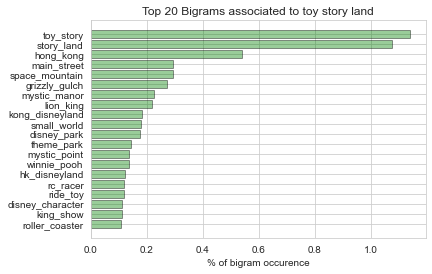

In [68]:
plt.barh(top20_bigram1['bigram_combo'], top20_bigram1['freq']/len(query_sample), color ='green', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of bigram occurence")
plt.gca().invert_yaxis()
plt.title("Top 20 Bigrams associated to toy story land")
plt.show()

In [64]:
trigram_filter1 = trigramFreqTable1[trigramFreqTable1.trigram.map(lambda x: rightTypes(x))]

test_string3 = trigram_filter1['trigram'].tolist()

trigram1 = [ ]
for c in range(0, len(test_string3)):
    trigram1.append(test_string3[c][0] + '_' + test_string3[c][1] + '_' + test_string3[c][2]) 

trigram_filter1['trigram_combo'] = trigram1
top20_trigram1 = trigram_filter1[:20]

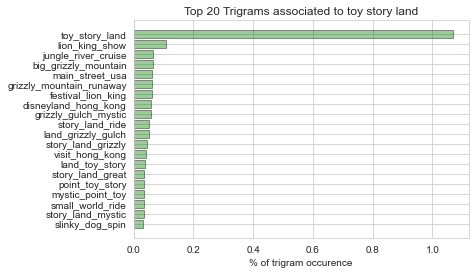

In [69]:
plt.barh(top20_trigram1['trigram_combo'], top20_trigram1['freq']/len(query_sample), color ='green', alpha = 0.4, 
         edgecolor = 'black', linewidth = 1)
plt.xlabel("% of trigram occurence")
plt.gca().invert_yaxis()
plt.title("Top 20 Trigrams associated to toy story land")

plt.show()

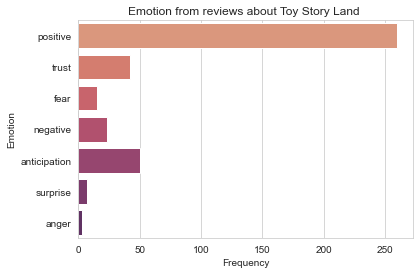

In [67]:
graph = sns.countplot(y="emotion", data=query_sample, palette="flare")
graph.set(xlabel='Frequency', ylabel='Emotion', title = 'Emotion from reviews about Toy Story Land ')
figure = graph.get_figure() 